In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [33]:
df = pd.read_csv("compressed_banding_videos.csv")
print(df.head())

  Codec  CRF                         Ref  \
0  H265   51  A007C031_171117_R2HN_0.yuv   
1  H265   51  A007C031_171117_R2HN_1.yuv   
2  H265   51  A007C031_171117_R2HN_2.yuv   
3  H265   51  A007C031_171117_R2HN_3.yuv   
4  H265   51  A007C031_171117_R2HN_4.yuv   

                                     Comp  \
0  A007C031_171117_R2HN_0_H265_CRF51_.yuv   
1  A007C031_171117_R2HN_1_H265_CRF51_.yuv   
2  A007C031_171117_R2HN_2_H265_CRF51_.yuv   
3  A007C031_171117_R2HN_3_H265_CRF51_.yuv   
4  A007C031_171117_R2HN_4_H265_CRF51_.yuv   

                               FileStream     PSNR_Y    PSNR_CB    PSNR_CR  \
0  A007C031_171117_R2HN_0_H265_CRF51_.txt  30.216760  37.181639  35.855909   
1  A007C031_171117_R2HN_1_H265_CRF51_.txt  30.222734  37.031661  35.454974   
2  A007C031_171117_R2HN_2_H265_CRF51_.txt  30.198305  36.640558  35.064578   
3  A007C031_171117_R2HN_3_H265_CRF51_.txt  29.956758  36.933436  35.328288   
4  A007C031_171117_R2HN_4_H265_CRF51_.txt  30.241319  36.897751  35.306441

In [34]:
X = df.iloc[:,2]
print(X)

0       A007C031_171117_R2HN_0.yuv
1       A007C031_171117_R2HN_1.yuv
2       A007C031_171117_R2HN_2.yuv
3       A007C031_171117_R2HN_3.yuv
4       A007C031_171117_R2HN_4.yuv
                   ...            
1414                WITCHER3_9.yuv
1415                WITCHER3_9.yuv
1416                WITCHER3_9.yuv
1417                WITCHER3_9.yuv
1418                WITCHER3_9.yuv
Name: Ref, Length: 1419, dtype: object


0        7.002224
1        5.223449
2        5.189551
3        5.544820
4        6.459658
          ...    
1414    11.835718
1415    10.365605
1416    12.891230
1417     8.687084
1418     5.806720
Name: CAMBI, Length: 1419, dtype: float64


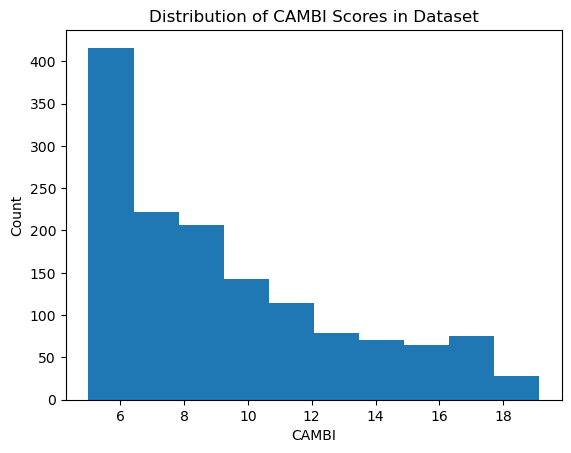

In [35]:
y = df.iloc[:,9]
print(y)
fig = plt.figure()
ax = fig.add_subplot()

ax.hist(y)
ax.set_xlabel("CAMBI"); ax.set_ylabel("Count")
ax.set_title("Distribution of CAMBI Scores in Dataset")
plt.show()

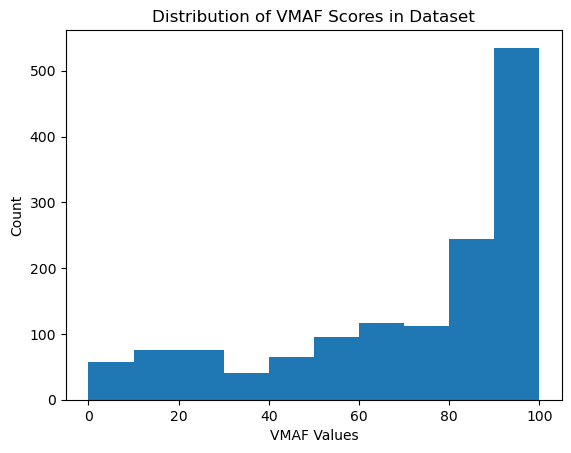

In [36]:
vmafScores = df.iloc[:,10]
fig = plt.figure()
ax = fig.add_subplot()

ax.hist(vmafScores)
ax.set_xlabel("VMAF Values"); ax.set_ylabel("Count")
ax.set_title("Distribution of VMAF Scores in Dataset")
plt.show()

In [37]:
train, test = train_test_split(df, shuffle=True, random_state=42,stratify=df.iloc[:,2])

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [32]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [7]:
print(X_train)


188                            A007C038_171117_R2HN_0.yuv
432     aom_meridian_3840x2160_5994_hdr10_20988-21412.yuv
411           aom_cosmos_3840x2160_24_hdr10_9561-9789.yuv
843     Dolby_Atmos_Natures_Fury_1920x1080_ATMOS_71-th...
471       aom_nocturne_3840x2160_60_hdr10_32660-32799.yuv
                              ...                        
1095    FlowingRiverMedSpeedLowGran_300frames_1920x108...
1130                                           GTAV_9.yuv
1294                                      STARCRAFT_9.yuv
860     Dolby_Atmos_Natures_Fury_1920x1080_ATMOS_71-th...
1126                                           GTAV_8.yuv
Name: Ref, Length: 1135, dtype: object


In [8]:
print(X_test)

51                             A007C035_171117_R2HN_3.yuv
289                            A007C041_171117_R2HN_4.yuv
677     DBubblesPitcherS1BVITexture_480x272_120fps_10b...
1005         DSparklerBVIHFR_480x272_120fps_10bit_420.yuv
367           AFireS71Mitch_3840x2176_24fps_10bit_420.yuv
                              ...                        
1290                                      STARCRAFT_1.yuv
351     ACloudsStaticBVITexture_3840x2176_120fps_10bit...
1299                SteamMedSpeed_300frames_1920x1080.yuv
1409                                       WITCHER3_8.yuv
549           BFireS21Mitch_1920x1088_24fps_10bit_420.yuv
Name: Ref, Length: 284, dtype: object


In [9]:
print(y_train)

188      5.276022
432      5.263998
411     11.371365
843      8.750428
471     10.345492
          ...    
1095    17.562161
1130     6.424832
1294     5.231174
860     14.814053
1126     5.676618
Name: CAMBI, Length: 1135, dtype: float64


In [10]:
print(y_test)

51      16.870492
289      9.161175
677     15.941945
1005     5.533873
367      6.587240
          ...    
1290     6.049121
351     12.127491
1299     7.211969
1409     6.043208
549      6.511519
Name: CAMBI, Length: 284, dtype: float64


In [ ]:
df = pd.read_csv("datasetDF.csv")
#print(df.head())
cambiScores = df.iloc[:,9]

In [ ]:
print(cambiScores)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()

ax.hist(cambiScores)
ax.set_xlabel("CAMBI"); ax.set_ylabel("Count")
ax.set_title("Distribution of CAMBI Scores in Dataset")
plt.show()

In [ ]:
psnr_y = df.iloc[:,5]
fig = plt.figure()
ax = fig.add_subplot()

ax.hist(psnr_y)
ax.set_xlabel("PSNR_Y Values"); ax.set_ylabel("Count")
ax.set_title("Distribution of PSNR_Y in Dataset")
plt.show()


In [ ]:
ssim = df.iloc[:,8]
fig = plt.figure()
ax = fig.add_subplot()

ax.hist(ssim)
ax.set_xlabel("SSIM Values"); ax.set_ylabel("Count")
ax.set_title("Distribution of SSIM in Dataset")
plt.show()


In [ ]:
vmafScores = df.iloc[:,10]
fig = plt.figure()
ax = fig.add_subplot()

ax.hist(vmafScores)
ax.set_xlabel("VMAF Values"); ax.set_ylabel("Count")
ax.set_title("Distribution of VMAF Scores in Dataset")
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(psnr_y,cambiScores)
ax.set_xlabel("PSNR_Y"); ax.set_ylabel("CAMBI")
ax.set_title("Distribution of CAMBI Scores vs. PSNR_Y in Dataset")
plt.show()


In [ ]:
fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(vmafScores,cambiScores)
ax.set_xlabel("VMAF"); ax.set_ylabel("CAMBI")
ax.set_title("Distribution of CAMBI Scores vs. VMAF in Dataset")
plt.show()